In [1]:
# IMPORTS

import csv
import os
import random
from neuron import h, gui
from neuron.units import ms, mV, um, V, cm
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from tqdm.notebook import tqdm

from time import time
import os.path

from socket import gethostname

h.load_file('model-files/basal_project.hoc')

1.0

In [3]:
# BARDIA CELL INITIATION (ALTERED)

ratio=0
loc=10
nsyn=0
sec=h.a1_111

dendrec=True

print(f'\n%s .... Starting Run' % (gethostname()))
iotim = 0
tic = time()

h.synrec = 1

h.tsamp = h.tstop/h.dt+1
h.synrec = 1
tsamp = int(h.tsamp)

r = h.Random(h.luckyoffset)
r.negexp(h.meanisi)

# h.a1_111.nseg = int(np.floor(h.a1_111.L))
# h.a1_111.nseg = int(np.floor(h.a1_111.L)/2)
seclist = [h.a1_111,
           h.a9_122,
           h.a10_11,
           h.a5_1,
           h.a8_11,
           h.a3_11,
           h.a9_122,
           h.a9_121,
           h.a8_122,
           h.a8_121,
           h.a7_111]

sl2 = h.SectionList()
for sec in seclist:
    sl2.append(sec = sec)
poppedsecs = sl2.unique()
h.refreshnseg(h.makeactivelist(sl2))
print(f'nseg: %d' % (h.nsegcnt()))
h.cvode.cache_efficient(1)
h.cvode_active(0)
h.poisson = 0


Christophers-MacBook-Pro.local .... Starting Run
nseg: 787


In [4]:
######################### BIOPHYSICAL FUNCTIONS #########################

def add_spines(branches):
    
    """
    Adds spines to all branches within the branch list
    5 spines per segment on each branch
    
    Returns nested list of spines within each branch 
    """
    
    # Intialize vectors for the spine head/neck
    spine_head = []
    spine_neck = []
    
    # Iterates through the number of branches of interest (list)
    num_branch = len(branches)
    for j in range(num_branch):
        
        
        # branches[j].nseg = int((np.floor(branches[j].L)) / 4)
        spine_head_temp = []
        spine_neck_temp = []

        # Number of spines: 5 per segment
        n_spines = branches[j].nseg * 5

        # Iterate through the number of spines for the particular branch
        for i in range(n_spines):
            
            # Create head and neck biophysical parameters
            spine_head_temp.append(h.Section())
            spine_neck_temp.append(h.Section())

            spine_head_temp[-1].L = 0.5
            spine_head_temp[-1].diam = 0.5
            spine_head_temp[-1].Ra = 100
            spine_head_temp[-1].insert('pas')
            for seg in spine_head_temp[-1]:
                seg.pas.e = -70
                seg.pas.g = 0.00005

            spine_neck_temp[-1].L = 1.5
            spine_neck_temp[-1].diam = 0.25
            spine_neck_temp[-1].Ra = 100
            spine_neck_temp[-1].insert('pas')
            for seg in spine_neck_temp[-1]:
                seg.pas.e = -70
                seg.pas.g = 0.00005
    
            # Connect head and neck together; then connect neck to branch
            spine_neck_temp[-1].connect(branches[j]((i+1)/n_spines))
            spine_head_temp[-1].connect(spine_neck_temp[-1])
        
        
        spine_head.append(spine_neck_temp)
        spine_neck.append(spine_head_temp)
    
    return spine_neck, spine_head

def add_inhib_soma(num):
    """
    Adds GABA synapses to the soma
    num: number of synapses
    
    Returns list of GABA synapses on the soma

    """

    syn_gaba_soma = []
    for i in range(num):
        syn_gaba_soma.append(h.GABAa_S(h.soma(0.5)))
        
    return syn_gaba_soma
    
def add_syn(branches, inhib=False):
    
    """
    Adds AMPA, NMDA, and GABA synaptic channels to a list of branches
    branches: list of branches
    inhib: boolean, determines if inhibitory synapses will be added to the branches
    
    Returns three nested vectors containing the synapses
    """

    syn_ampa = []
    syn_nmda = []
    syn_gaba = []
    
    num_branch = len(branches)
    
    # Iterates through the number of branches and applies synapses to every spine
    for j in range(num_branch):
        
        syn_ampa_temp = []
        syn_nmda_temp = []
        syn_gaba_temp = []
        
        # Indexes spine heads of the current branch
        n_spines = len(spine_head[j])
        for i in range(n_spines):
            
            # adds AMPA, NMDA, and GABA synapses to each spine
            syn_ampa_temp.append(h.Exp2Syn(spine_head[j][i](0.5)))
            syn_nmda_temp.append(h.Exp2SynNMDA(spine_head[j][i](0.5)))
            syn_ampa_temp[-1].e = 0
            syn_ampa_temp[-1].tau1 = 0.05
            syn_ampa_temp[-1].tau2 = 0.5
            syn_nmda_temp[-1].e = 0
            syn_nmda_temp[-1].tau1 = 2.1
            syn_nmda_temp[-1].tau2 = 18.8
            
            if inhib:
                syn_gaba_temp.append(h.GABAa_S(spine_head[j][i](0.5)))
            
        syn_ampa.append(syn_ampa_temp)
        syn_nmda.append(syn_nmda_temp)
        syn_gaba.append(syn_gaba_temp)
    
    return syn_ampa, syn_nmda, syn_gaba

######################### CURRENT INJECTIONS ############################

def frequency_counter(t_vec, v_vec):
    """
    Returns the frequency of spikes measured at the soma
    
    t_vec: time vector
    v_vec: voltage vector
    
    """
    
    # Chops off the first 100ms, in which the model is still reaching steady-state
    t_tot = t_vec[-1]
    start_t_i = np.where(np.floor(t_vec)==100)[0][0]
    
    spike_counter = 0
    length_v = len(v_vec)
    
    # Iterates from 100ms to end of time for the vector; calculates spikes
    for i in range(start_t_i, length_v-1):
        if v_vec[i] < 0 and v_vec[i+1] >= 0:
            spike_counter += 1
    
    # Determines the frequency of spikes
    frequency = (spike_counter/(t_tot-100)) * 10 ** 3
    
    return frequency

def fi_curve(adj,
             adj_var,
             max_c, 
             inc, 
             avg):
    
    """
    Generates an FI curve through injecting increasing current into the soma
    
    max_c: the maximum amount of injected current at the soma (nA)
    inc: the size step of the amount of current (nA)
    avg: the number of times each FI point will be averaged along the curve
    g: conductance of GABA synapses
    dtb: distribution of GABA synpse firing
    """
    
    h.tstop = 1000 # ms
    h.v_init = -70 # mV
    
    frequency_list = []
    
    # Iterates through increasing current injections
    for amp in tqdm(np.linspace(0, max_c, int(max_c/inc + 1))):
        
        f_trial = []
        
        # Performs averaged trials at a specific current value
        for j in range(avg):

            adjust, stim_obj, current, tt = current_injection(amp_adj_x=adj, adj_var_x=adj_var)
            
            # Creates current injection
            temp = []
            temp = h.IClamp(h.soma(1))
            temp.delay = 0
            temp.dur = 1e9
            temp.amp = amp
            
            # Calculates voltage trace
            soma_v = h.Vector().record(h.soma(1)._ref_v)
            t_vec = h.Vector().record(h._ref_t)
            h.finitialize()
            h.run()

            f_trial.append(frequency_counter(t_vec, soma_v))
            temp = None

            adjust = None
            stim_obj = None
            current = None
            tt = None
        
        frequency = np.mean(np.array(f_trial))
        frequency_list.append(frequency)
    
    amp_list = np.linspace(0, max_c, int(max_c/inc + 1))

    return amp_list, frequency_list

##################### SYNAPSE BEHAVIOR ##########################

def create_stim(interval=10, num=3, start=5, noise=0, s=1):
    
    """
    Creates a stimulator object used as the pre-synaptic stimulus
    interval: amount of time between stimulation events (ms)
    num: the number of stimulation events
    start: delay of stimulation (ms)
    s: seed number
    """
    
    stim = h.NetStim()
    stim.interval = interval
    stim.number = num
    stim.start = start
    stim.noise = noise
    
    return stim

def current_injection(amp_adj_x, adj_var_x):

    tt = h.Vector(np.linspace(0, h.tstop, int(h.tstop/h.dt)))
    current = np.random.normal(amp_adj_x, adj_var_x, len(tt))
    
    adjust = h.Vector()
    adjust.from_python(current)
    stim_obj = h.IClamp(h.soma(0.5))
    stim_obj.delay = 0  # ms
    stim_obj.dur = 1e9  # ms
    adjust.play(stim_obj._ref_amp, tt, True)
    
    return adjust, stim_obj, current, tt

In [5]:
basal_dendrites = [h.a1_111,
                   h.a9_122,
                   h.a10_11,
                   h.a5_1,
                   h.a8_11,
                   h.a3_11,
                   h.a9_122,
                   h.a9_121,
                   h.a8_122,
                   h.a8_121,
                   h.a7_111]

In [7]:
n_gaba = 30

spine_neck, spine_head = add_spines(basal_dendrites)
syn_ampa, syn_nmda, syn_gaba = add_syn(basal_dendrites, inhib=True)
syn_gaba_soma = add_inhib_soma(n_gaba)

In [8]:
i_1, f_1 = fi_curve(adj=0.75,
                    adj_var=1,
                    max_c=0.6,
                    inc=0.01,
                    avg=1)


filename = "noisy-background/fi-collection/trial" + str(trial) + ".csv"

with open(filename, 'w', newline='') as f:
     
    # using csv.writer method from CSV package
    write = csv.writer(f, delimiter=',')
    write.writerow(i_1)
    write.writerow(f_1)

  0%|          | 0/61 [00:00<?, ?it/s]

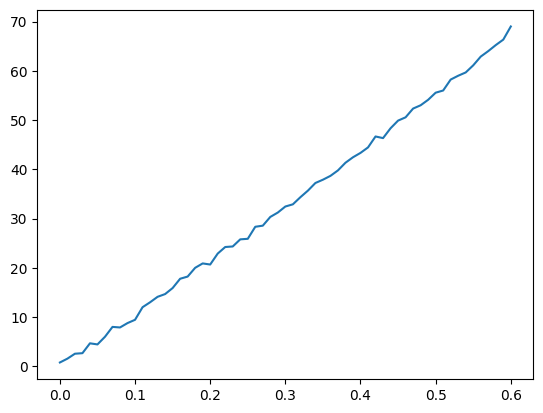